# SNP/Phenotype detection from raw text

In [1]:
%load_ext autoreload
%autoreload 2

import sys

In [2]:
# import snorkel and gwasdb
sys.path.append('../snorkel')
sys.path.append('../src')

# set up paths
abstract_dir = '../data/db/papers'

## Assemble a corpus

We will look at abstracts for now

In [3]:
from snorkel.parser import XMLDocParser
from extractor.parser import UnicodeXMLDocParser

xml_parser = UnicodeXMLDocParser(
    path=abstract_dir,
    doc='./*',
    text='.//abstract/p//text()',
    id='.//article-id[@pub-id-type="pmid"]/text()',
    keep_xml_tree=True)

Warning: there are unicode chars that cause trouble, e.g.:

In [437]:
import unicodedata
print u'\u2212 8'
txt=u'\xd7'
print unicodedata.normalize('NFKD', txt).encode('ascii','ignore')
print unicode(txt)

− 8

×


Get the actual docs:

In [438]:
import lxml.etree as et
with open('../data/db/papers/19305408.xml') as f:
    for i,doc in enumerate(et.parse(f).xpath('./*')):
        print doc
        print doc.xpath('.//abstract/p//text()')

<Element article at 0x1495dd7e8>
[u'QT interval duration reflecting myocardial repolarization on the electrocardiogram is a heritable risk factor for sudden cardiac death and drug-induced arrhythmias. We conducted a meta-analysis of 3 genome-wide association studies in 13,685 individuals of European ancestry from the Framingham Heart Study, the Rotterdam Study and the Cardiovascular Health Study. We observed associations at P < 5\xd710', u'\u22128', ' with variants in ', 'NOS1AP', ', ', 'KCNQ1, KCNE1', ', ', 'KCNH2', ' and ', 'SCN5A', ', known to be involved in myocardial repolarization and Mendelian Long QT Syndromes. Associations at five novel loci included 16q21 near ', 'NDRG4', ' and ', 'GINS3', ', 6q22 near ', 'PLN', ', 1p36 near ', 'RNF207', ', 16p13 near ', 'LITAF', ' and 17q12 near ', 'LIG3', ' and ', 'RIFFL', u'. Collectively, the 14 independent variants at these 10 loci explain 5.4\u20136.5% of variation in QT interval. Identifying the causal variants and defining their impac

In [4]:
from snorkel.parser import SentenceParser
from snorkel.parser import CorpusParser

sent_parser = SentenceParser()
corpus_parser = CorpusParser(xml_parser, sent_parser)
%time corpus = corpus_parser.parse_corpus()

CPU times: user 9.51 s, sys: 1.07 s, total: 10.6 s
Wall time: 1min 18s


Test the results:

In [15]:
doc = corpus.documents[2]
print doc

for doc in corpus.documents:
    if doc.name is None: 
        print doc

Document('17684544', Corpus (None))


In [6]:
sent = corpus.get_sentences()[0]
print sent

Sentence(Document('17447842', Corpus (None)), 0, u'To identify novel susceptibility loci for Crohn disease (CD), we undertook a genome-wide association study with more than 300,000 SNPs characterized in 547 patients and 928 controls.')


## Try extracting rs-ids first

In [7]:
# add new paths
sys.path.append('../src/crawler')
sys.path.append('../src/crawler/db')

# import new libs
from kb import KnowledgeBase
from extractor.util import gold_rsid_stats, gold_rsid_precision

from snorkel.candidates import Ngrams
from snorkel.matchers import DictionaryMatch, RegexMatchSpan, Union
from snorkel.candidates import EntityExtractor

# from snorkel.candidates import Candidates

### Create a gold set

Get a list of all the rs-ids we know.

In [8]:
kb = KnowledgeBase()

In [9]:
rs_ids = kb.get_rsid_candidates()
print rs_ids[0]

rs1000113


Get a gold set:

In [17]:
gold_set = frozenset( [ (doc.name, rs_id) for doc in corpus.documents for rs_id in kb.rsids_by_pmid(int(doc.name)) ] )

In [18]:
gold_set_rsids = [rs_id for doc_id, rs_id in gold_set]

### Extract candidates:

In [20]:
from snorkel.candidates import EntityExtractor
# Define a candidate space
ngrams = Ngrams(n_max=1)

# Define matchers
dict_rsid_matcher = DictionaryMatch(d=rs_ids, longest_match_only=False)
gold_rsid_matcher = DictionaryMatch(d=gold_set_rsids, longest_match_only=False)
regx_rsid_matcher = RegexMatchSpan(rgx=r'rs\d+')
rsid_matcher = Union(dict_rsid_matcher, regx_rsid_matcher)

rsid_extractor = EntityExtractor(ngrams, rsid_matcher)
%time rs_candidates = rsid_extractor.extract(corpus.get_sentences(), name='all')
for cand in rs_candidates[:10]: 
    print cand
print "%s candidates extracted" % len(candidates)

# # collect candidates
# %time gold_dict_c = Candidates(ngrams, gold_rsid_matcher, corpus.get_contexts())
# %time rsid_c = Candidates(ngrams, rsid_matcher, corpus.get_contexts())

AttributeError: 'Sentence' object has no attribute 'cell'

In [15]:
print 'Got %d candidates, e.g.:' % len(rsid_c.get_candidates())
rsid_c.get_candidates()[:5]

Got 994 candidates, e.g.:


[<Ngram("rs1667255", id=21878437-2:704-712, chars=[704,712], words=[38,38]),
 <Ngram("rs7868992", id=22889924-4:983-991, chars=[983,991], words=[30,30]),
 <Ngram("rs10198628", id=22589742-17:2336-2345, chars=[2336,2345], words=[0,0]),
 <Ngram("rs455804", id=22807686-14:2226-2233, chars=[2226,2233], words=[3,3]),
 <Ngram("rs3093077", id=22291609-5:1571-1579, chars=[1571,1579], words=[98,98])]

### Statistics

Statistics on all the rsid candidates:

In [16]:
gold_rsid_stats(rsid_c.get_candidates(), gold_set)

# of gold annotations	= 8384
# of candidates		= 792
Candidate recall	= 0.068
Candidate precision	= 0.722


Statistics on the candidates extracted via dictionary matching.

Recall is how many SNPs in the gold set are actually mentioned in the abstract/txt.
Precision is how many recovered SNPs are also found in the gold set.

The gold set are (pmid, rsid) tuples, so in some cases, there are papers where there is a mention of an rsid from another paper, but this new mention is not recorded in the gold set.

In [17]:
gold_rsid_stats(gold_dict_c.get_candidates(), gold_set)

# of gold annotations	= 8384
# of candidates		= 621
Candidate recall	= 0.068
Candidate precision	= 0.921


Some debugging on the largest rsID candate set:

In [18]:
strange_ngrams = gold_rsid_precision(rsid_c.get_candidates(), gold_set)
gold_dict = dict(gold_set)
for ngram in strange_ngrams[:5]:
    print ngram
    # print corpus.get_doc(ngram.doc_id)
    print ' '.join(ngram.sentence['words'])

<Ngram("rs3093077", id=22291609-5:1571-1579, chars=[1571,1579], words=[98,98])
Novel signals include : for IL-6 , in the ABO gene -LRB- rs657152 , p = 2.13 × 10 − 29 -RRB- ; for ESR , at the HBB -LRB- rs4910472 , p = 2.31 × 10 − 11 -RRB- and UCN119B / SPPL3 -LRB- rs11829037 , p = 8.91 × 10 − 10 -RRB- loci ; for MCP-1 , near its receptor CCR2 -LRB- rs17141006 , p = 7.53 × 10 − 13 -RRB- and in CADM3 -LRB- rs3026968 , p = 7.63 × 10 − 13 -RRB- ; for hsCRP , within the CRP gene -LRB- rs3093077 , p = 5.73 × 10 − 21 -RRB- , near DARC -LRB- rs3845624 , p = 1.43 × 10 − 10 -RRB- , UNC119B / SPPL3 -LRB- rs11829037 , p = 1.50 × 10 − 14 -RRB- , and ICOSLG/AIRE -LRB- rs113459440 , p = 1.54 × 10 − 08 -RRB- loci .
<Ngram("rs1572312", id=25729143-7:991-999, chars=[991,999], words=[9,9])
The C allele of the most significant SNP , rs1572312 , was associated with high values of V .
<Ngram("rs1572312", id=25729143-9:1130-1138, chars=[1130,1138], words=[6,6])
Furthermore , the frequency of the rs1572312 C a

## Get candidate p-values

Need to use regular expressions for this.

In [19]:
from snorkel.matchers import RegexMatchSpan

Test out the regexp.

In [20]:
import re

#p (whitespace)? = (whitespace)? \d+ .? \d? (whitespace?) "x symbol" (whitespace?) 10 (whitespace?) "- symbol" \w?\d+
# rgx = u'p\s*=\s*\d+\.?\d*\s*\xd7\s*10\s*\u2212\s*\d+'
rgx = u'\d+\.?\d*\s*\xd7\s*10\s*\u2212\s*\d+'
sentence = ' '.join(strange_ngrams[4].sentence['words'])
print sentence
print re.search(rgx, sentence).group()

Next , case-control studies resulted in remaining three SNPs -LRB- NFIA-AS2 rs1572312 , TSHR rs7144481 , RBFOX1 rs7191721 -RRB- associated with endurance athlete status .


AttributeError: 'NoneType' object has no attribute 'group'

In [21]:
pval_matcher = RegexMatchSpan(rgx=rgx)
ngrams = Ngrams(n_max=5)
%time pval_c = Candidates(ngrams, pval_matcher, corpus.get_contexts())

Extracting candidates...
CPU times: user 13 s, sys: 84.5 ms, total: 13.1 s
Wall time: 13.1 s


In [29]:
print 'Got %d candidates, e.g.:' % len(pval_c.get_candidates())
for candidate in pval_c.get_candidates()[:5]:
    print unicode(candidate)

Got 1013 candidates, e.g.:
<Ngram("1.2×10 −15", id=22792071-4:978-987, chars=[978,987], words=[50,54])
<Ngram("1.2×10 −11", id=20173748-2:485-494, chars=[485,494], words=[46,50])
<Ngram("1.85×10 −20", id=18846228-5:782-792, chars=[782,792], words=[41,45])
<Ngram("6.2×10 −5", id=24586183-6:1550-1558, chars=[1550,1558], words=[60,64])
<Ngram("1.5×10 −7", id=18464913-6:1097-1105, chars=[1097,1105], words=[60,64])


### Statistics

First, how many p-values that should be present do we extract?

In [58]:
# we need to define a p-value -> float converter
from extractor.util import pvalue_to_float, gold_pval_stats, gold_pval_precision

print pvalue_to_float(u"6.2×10 −5")
print pvalue_to_float(u"1.85×10 −20")

6.2e-05
1.85e-20


In [27]:
from kb import KnowledgeBase
kb = KnowledgeBase()
gold_set_pvals = frozenset([ (doc.id, pval) for doc in corpus.get_docs() for pval in kb.pvals_by_pmid(int(doc.id)) ])

In [45]:
print 'Found %d gold mentions, e.g.:' % len(gold_set_pvals)
print list(gold_set_pvals)[:5]
print

print gold_pval_stats(pval_c.get_candidates(), gold_set_pvals)

Found 5289 gold mentions, e.g.:
[('23770605', 1e-14), ('23326517', 7.000000000000001e-32), ('19936222', 2e-53), ('24586186', 3e-164), ('24999842', 3e-11)]

# of gold annotations	= 2730
# of candidates		= 798
Candidate recall	= 0.182
Candidate precision	= 0.623
None


Some debugging...

In [70]:
print gold_pval_precision(pval_c.get_candidates(), gold_set_pvals)

[('23900074', -10.0), ('22479202', -4.0), ('21878437', -5.0), ('22832960', -8.0), ('21738479', -8.0), ('19714205', -6.0), ('22291609', -29.0), ('18483556', -62.0), ('22737229', -12.0), ('21729881', -8.0), ('24586183', -4.0), ('22368281', -16.0), ('21079607', -7.0), ('19412175', -8.0), ('22479202', -43.0), ('25436638', -3.0), ('24586183', -5.0), ('19503597', -54.0), ('24940741', -11.0), ('23565137', -8.0), ('21814517', -8.0), ('20852633', -11.0), ('22479419', -5.0), ('23459443', -8.0), ('21533024', -16.0), ('24379826', -3.0), ('19503597', -26.0), ('22005930', -4.0), ('21326860', -5.0), ('21124946', -5.0), ('24023788', -3.0), ('23583978', -11.0), ('21124955', -11.0), ('23900074', -4.0), ('25017104', -16.0), ('18282107', -5.0), ('21273288', -10.0), ('23966204', -37.0), ('19915575', -5.0), ('20585626', -25.0), ('20838585', -24.0), ('21460840', -21.0), ('18776929', -7.0), ('21418511', -4.0), ('19056611', -14.0), ('21533024', -9.0), ('22479202', -5.0), ('22558097', -8.0), ('20921969', -5.0),

In [76]:
gold_pval_dict = { doc_id : [] for doc_id, pval in gold_set_pvals }
for doc_id, pval in gold_set_pvals:
    gold_pval_dict[doc_id].append(pval)
    
strange_ngrams = gold_pval_precision(pval_c.get_candidates(), gold_set_pvals)
for ngram in strange_ngrams[:5]:
    print unicode(ngram)
    print ' '.join(ngram.sentence['words'])
    print gold_pval_dict[ngram.doc_id]
    print

<Ngram("6.2×10 −5", id=24586183-6:1550-1558, chars=[1550,1558], words=[60,64])
The MAGI3 and BACH2 variants were associated with an increased risk of hyperthyroidism , which was replicated in an independent cohort of patients with Graves ' disease -LRB- OR : 1.37 , 95 % CI 1.22 -- 1.54 , P = 1.2 × 10 − 7 and OR : 1.25 , 95 % CI 1.12 -- 1.39 , P = 6.2 × 10 − 5 -RRB- .
[1e-09, 3e-06, 3e-07, 3.0000000000000004e-08, 4e-08, 7e-13, 4e-07, 2e-16, 6e-07, 2e-08, 1e-07]

<Ngram("2.44×10 −3", id=18776929-6:1145-1154, chars=[1145,1154], words=[31,35])
Two SNPs of the PLCL1 gene , rs892515 and rs9789480 , surrounded by the four SNPs identified in our GWAS , achieved p values of 8.62 × 10 − 3 and 2.44 × 10 − 3 , respectively , for association with hip BS .
[2e-06]

<Ngram("5.43 × 10 −4", id=21483430-5:1469-1480, chars=[1469,1480], words=[113,117])
Associated regions affiliated with memory included the entorhinal cortex -LRB- rs821639 , p = 4.11 × 10 − 5 ; rs2356606 , p = 4.71 × 10 − 4 -RRB- , cingul

In [ ]:
kb.pvals_by_pmid('23382691')

Potential analysis question: how many rsIDs that we extracted earlier also have an associated p-value?

We will say that if an rsID and a p-value occur in the same document, they have been identified correctly.

So we extract from our gold set tuples of the form (pmid, rsID, p-value). We compare them to candidate tuples, where an rsID and a p-value are associated if they occur in the same sentence.

This seems like something to be checked at the relation extraction stage.

## Extract phenotypes

In [83]:
# Define a candidate space
ngrams = Ngrams(n_max=4)

# collect phenotype list
from db.kb import KnowledgeBase
kb = KnowledgeBase()
phenotype_list = kb.get_phenotype_candidates()
# TODO: load disease names from NCBI

# Define matchers
phen_matcher = DictionaryMatch(d=phenotype_list, longest_match_only=False, ignore_case=True, stemmer='porter')

# collect candidates
%time phen_c = Candidates(ngrams, phen_matcher, corpus.get_contexts())

Extracting candidates...
CPU times: user 21.2 s, sys: 142 ms, total: 21.4 s
Wall time: 21.4 s


In [84]:
print 'Got %d candidates, e.g.:' % len(phen_c.get_candidates())
for candidate in phen_c.get_candidates()[:5]:
    print candidate

Got 2429 candidates, e.g.:
<Ngram("quantitative trait", id=20190752-4:597-614, chars=[597,614], words=[3,4])
<Ngram("anthropometric traits", id=21423719-8:1757-1777, chars=[1757,1777], words=[20,21])
<Ngram("systemic sclerosis", id=21779181-0:164-181, chars=[164,181], words=[27,28])
<Ngram("type 2 diabetes", id=25102180-11:1961-1975, chars=[1961,1975], words=[5,7])
<Ngram("hepatic", id=21423719-13:2404-2410, chars=[2404,2410], words=[15,15])


### Statistics

In [106]:
from db.kb import KnowledgeBase
kb = KnowledgeBase() # reload
gold_set_phens = frozenset([ (doc.id, phen) for doc in corpus.get_docs() for phen in kb.phens_by_pmid(int(doc.id)) ])

print 'Found %d gold mentions, e.g.:' % len(gold_set_phens)
print list(gold_set_phens)[:5]

Found 723 gold mentions, e.g.:
[('24478790', u'telomere length'), ('21552555', u'obesity'), ('18483556', u'black vs. red hair color'), ('22359512', u'phospholipid levels (plasma)'), ('22479202', u'adiponectin levels')]


In [104]:
from extractor.util import gold_phen_stats
gold_phen_stats(phen_c.get_candidates(), gold_set_phens)

# of gold annotations	= 723
# of candidates		= 2429
Candidate recall	= 0.939
Candidate precision	= 0.280


Why do we get low recall?

In [114]:
from extractor.util import gold_phen_recall
kb = KnowledgeBase()

phen_not_found = gold_phen_recall(phen_c.get_candidates(), gold_set_phens)
for doc_id, phen in phen_not_found[:5]:
    print phen
    print kb.title_by_pmid(doc_id)
    print corpus.get_doc(doc_id)
    print

word reading
A genome-wide association study for reading and language abilities in two population cohorts.
Document(id='23738518', file='23738518.xml', text=u'Candidate genes have been identified for both reading and language, but most of the heritable variance in these traits remains unexplained. Here, we report a genome-wide association meta-analysis of two large cohorts: population samples of Australian twins and siblings aged 12\u201325\u2009years ( n \u2009=\u20091177 from 538 families), and a younger cohort of children of the UK Avon Longitudinal Study of Parents and their Children (aged 8 and 9\u2009years; maximum  n \u2009=\u20095472). Suggestive association was indicated for reading measures and non-word repetition (NWR), with the greatest support found for single nucleotide polymorphisms (SNPs) in the pseudogene,  ABCC13  ( P \u2009=\u20097.34\u2009\xd7\u200910 \u22128 ), and the gene,  DAZAP1  ( P \u2009=\u20091.32\u2009\xd7\u200910 \u22126 ). Gene-based analyses showed sign

## Now let's do some learning!

### Learning correct phenotypes

In [201]:
from snorkel.matchers import CandidateExtractor
from snorkel.snorkel import Entities

from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

ngrams = Ngrams(n_max=4)
ce = CandidateExtractor(ngrams, phen_matcher)

phenotypes = Entities(corpus.get_contexts(), ce)

Extract features, and store them to a file.

In [202]:
import cPickle
feats = None

pkl_f = 'phenotype_feats.pkl'
try:
    with open(pkl_f, 'rb') as f:
        feats = cPickle.load(f)
except:
    %time phenotypes.extract_features()
    feats = phenotypes.feats
    with open(pkl_f, 'w+') as f:
        cPickle.dump(feats, f)

Create the model.

In [203]:
from snorkel.snorkel import DDLiteModel

DDL = DDLiteModel(phenotypes, feats)
print "Extracted {} features for each of {} mentions".format(DDL.num_feats(), DDL.num_candidates())

Extracted 48076 features for each of 2429 mentions


We now create a gold truth set. Phenotype mentions are said to be correct if the phenotype is known to be mentioned in the document.

In [253]:
# small helper functions:
def get_doc_id(entity):
    return entity.uid.split('::')[0]

def get_phenotype(entity, stem=False):
    phenotype = ' '.join([entity.words[i] for i in entity.idxs])
    if stem:
        phenotype = stemmer.stem(phenotype)
    return phenotype.lower()
        
    
print phenotypes[0]
print phenotypes[0].uid
print get_doc_id(phenotypes[0])
print get_phenotype(phenotypes[0])

<Entity: [u'Wilms', u'tumor'][0, 1]>
Words: [u'Wilms', u'tumor', u'is', u'the', u'most', u'common', u'renal', u'malignancy', u'of', u'childhood', u'.']
Lemmas: [u'wilms', u'tumor', u'be', u'the', u'most', u'common', u'renal', u'malignancy', u'of', u'childhood', u'.']
POSES: [u'NN', u'NN', u'VBZ', u'DT', u'RBS', u'JJ', u'JJ', u'NN', u'IN', u'NN', u'.']
22544364::0::[[0, 1]]::['MATCHER']
22544364
wilms tumor


In [205]:
for i in range(5):
    print ' '.join(phenotypes[i].words)
#     print phenotypes[i]
    print

Wilms tumor is the most common renal malignancy of childhood .

We conclude that the currently known major common variants related to obesity overlap to a substantial degree between children and adults .

Variants in the Human Leukocyte Antigen -LRB- HLA -RRB- - DQ region were associated with age of onset -LRB- rs7744020 P = 7.9 × 10 − 9 beta − 1.9 years -RRB- and varied significantly among cases with onset after the 2009 H1N1 influenza pandemic compared to previous years -LRB- rs9271117 P = 7.8 × 10 − 10 OR 0.57 -RRB- .

We uncovered a new gene influencing waist circumference , the neurexin 3 gene -LRB- NRXN3 -RRB- , which has been previously implicated in studies of addiction and reward behavior .

We uncovered a new gene influencing waist circumference , the neurexin 3 gene -LRB- NRXN3 -RRB- , which has been previously implicated in studies of addiction and reward behavior .



In [269]:
# load true phenotype mentions
doc_ids = [get_doc_id(phen) for phen in phenotypes]
gold_phen_dict = { doc_id : kb.phens_by_pmid(doc_id) for doc_id in doc_ids}

In [270]:
# classify candidates as correct or not
uids = list()
gt = list()
for doc_id, phenotype in zip(doc_ids, phenotypes):
    uids.append(phenotype.uid)
    phenotype_name = get_phenotype(phenotype)
    if phenotype_name in gold_phen_dict[doc_id]:
        gt.append(+1)
    else:
        gt.append(-1)

In [271]:
DDL.update_gt(gt, uids=uids)
n_data = DDL.num_candidates()
idxs = np.arange(start=n_data/2, stop=n_data)
DDL.set_holdout(idxs)

#### Labeling functions

In [299]:
# load set of dictionary phenotypes
kb = KnowledgeBase()
phenotype_list = kb.get_phenotype_candidates() # TODO: load disease names from NCBI
phenotype_list = [stemmer.stem(phenotype) for phenotype in phenotype_list]
phenotype_set = set(phenotype_list)

def LF_in_set(m):
    return +1 if get_phenotype(m, stem=True) in phenotype_list else -1
def LF_associated(m):
    return +1 if 'associate' in m.pre_window('lemmas') else 0
def LF_influencing(m):
    return +1 if 'influence' in m.pre_window('lemmas') else 0
def LF_related(m):
    return +1 if 'relate' in m.pre_window('lemmas') else 0
def LF_phenotype(m):
    return +1 if 'phenotype' in m.pre_window('lemmas') or 'phenotype' in m.post_window('lemmas') else 0

# negative LFs
def LF_previously(m):
    return -1 if 'previously' in m.pre_window('lemmas', 8) else 0
def LF_obese(m):
    return -1 if 'obese' in m.mention('words') and len(m.mention('words')) == 1 else 0
def LF_further(m):
    return -1 if 'further' in m.lemmas or 'furthermore' in m.lemmas else 0
def LF_also(m):
    return -1 if 'also' in m.words else 0
def LF_age(m):
    return -1 if 'age' in m.mention('words') or 'aging' in m.mention('words') or 'ages' in m.mention('words') else 0
def LF_trait(m):
    return -1 if 'trait' in m.mention('lemmas') else 0
def LF_weight(m):
    return -1 if 'weight' in m.mention('lemmas') else 0
def LF_recently(m):
    return -1 if 'recently' in m.words else 0
def LF_addit(m):
    return -1 if 'addit' in m.lemmas else 0
def LF_may(m):
    return -1 if 'may' in m.words else 0
def LF_short(m):
    return -1 if len(m.mention('lemmas')) == 1 in m.lemmas else 0

In [306]:
LFs = [LF_associated, LF_influencing, LF_related, LF_previously, LF_phenotype, LF_obese, LF_further,
       LF_also, LF_age, LF_trait, LF_weight, LF_recently, LF_addit, LF_may, LF_short]
DDL.apply_lfs(LFs, clear=True)

In [312]:
stemmer.stem('previously')
# print phenotypes[4]
# m = phenotypes[4]
# print
# print m.lemmas[20]
# print m.lemmas[m.dep_parents[20]]
# print m.idxs
# print [m.lemmas[m.dep_children[i] - 1] for i in m.idxs]


u'previous'

In [313]:
# a bit of debugging
for i in range(80, 120):
    if gt[i] == -1:
        print ' '.join(phenotypes[i].words)
        print phenotypes[i]
        print [phenotypes[i].words[j] for j in phenotypes[i].idxs]
        print gt[i]
        print gold_phen_dict[doc_ids[i]]
    #     print phenotypes[i].pre_window('lemmas')
        for LF in LFs:
            print LF(phenotypes[i]),
        print '\n'

We sought to identify additional genetic variants influencing NAFLD using genome-wide association -LRB- GWA -RRB- analysis of computed tomography -LRB- CT -RRB- measured hepatic steatosis , a non-invasive measure of NAFLD , in large population based samples .
<Entity: [u'hepatic'][23]>
Words: [u'We', u'sought', u'to', u'identify', u'additional', u'genetic', u'variants', u'influencing', u'NAFLD', u'using', u'genome-wide', u'association', u'-LRB-', u'GWA', u'-RRB-', u'analysis', u'of', u'computed', u'tomography', u'-LRB-', u'CT', u'-RRB-', u'measured', u'hepatic', u'steatosis', u',', u'a', u'non-invasive', u'measure', u'of', u'NAFLD', u',', u'in', u'large', u'population', u'based', u'samples', u'.']
Lemmas: [u'we', u'seek', u'to', u'identify', u'additional', u'genetic', u'variant', u'influence', u'NAFLD', u'use', u'genome-wide', u'association', u'-lrb-', u'gwa', u'-rrb-', u'analysis', u'of', u'computed', u'tomography', u'-lrb-', u'ct', u'-rrb-', u'measure', u'hepatic', u'steatosis', u','

#### Results

LF stats on training set
Coverage:	31.301%
Overlap:	5.931%
Conflict:	3.460%


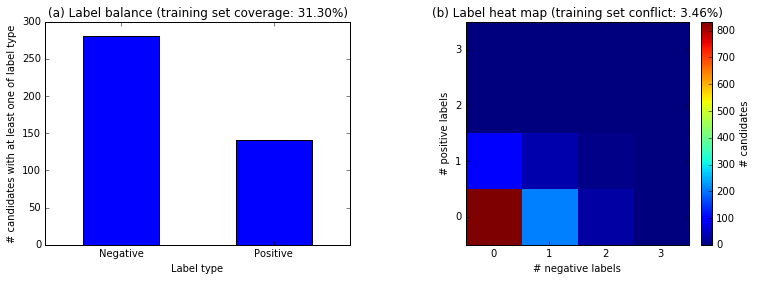

In [309]:
DDL.print_lf_stats()
DDL.plot_lf_stats()


Begin training for rate=0.01, mu=1e-07
	Learning epoch = 0	Gradient mag. = 0.100648
	Learning epoch = 250	Gradient mag. = 0.101439
Final gradient magnitude for rate=0.01, mu=1e-07: 0.100
Running in False mode...
Begin training for rate=0.01, mu=1e-09
	Learning epoch = 0	Gradient mag. = 0.017936
	Learning epoch = 250	Gradient mag. = 0.018712
	Learning epoch = 500	Gradient mag. = 0.018548
	Learning epoch = 750	Gradient mag. = 0.018388
	Learning epoch = 1000	Gradient mag. = 0.018231
	Learning epoch = 1250	Gradient mag. = 0.018078
	Learning epoch = 1500	Gradient mag. = 0.017929
	Learning epoch = 1750	Gradient mag. = 0.017783
	Learning epoch = 2000	Gradient mag. = 0.017640
	Learning epoch = 2250	Gradient mag. = 0.017500
	Learning epoch = 2500	Gradient mag. = 0.017364
	Learning epoch = 2750	Gradient mag. = 0.017231
Final gradient magnitude for rate=0.01, mu=1e-09: 0.017
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.017936
	Learning epoch = 250	Gradient mag. = 0

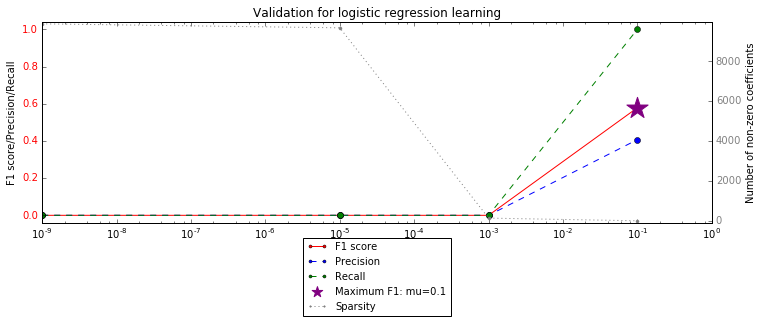

CPU times: user 28.4 s, sys: 417 ms, total: 28.8 s
Wall time: 29.1 s


<snorkel.snorkel.ModelLog instance at 0x14953cc68>

In [311]:
import matplotlib
import numpy as np
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (12,4)
mu_seq = np.ravel([1e-9, 1e-5, 1e-3, 1e-1])
lf_opts = {'sample': False, 'verbose': True}
model_opts = {'sample': False, 'n_iter': 3000, 'alpha': 0.5, 'mu': mu_seq, 'bias': False, 'verbose': True}
%time DDL.train_model(method='lr', lf_opts=lf_opts, model_opts=model_opts)

## Let's extract some relations!

In [324]:
from snorkel.matchers import CandidateExtractor
from snorkel.snorkel import Relations

ngrams = Ngrams(n_max=5)
rsid_extractor = CandidateExtractor(ngrams, rsid_matcher)
pval_extractor = CandidateExtractor(ngrams, pval_matcher)

pval_relations = Relations(corpus.get_contexts(), rsid_extractor, pval_extractor)

Again, extract features.

In [329]:
%time pval_relations.extract_features()
feats = pval_relations.feats
with open(pkl_f, 'w+') as f:
    cPickle.dump(feats, f)

CPU times: user 12min 25s, sys: 1.7 s, total: 12min 27s
Wall time: 12min 35s


In [328]:
import cPickle
feats = None

pkl_f = 'pval_rel_feats.pkl'
try:
    with open(pkl_f, 'rb') as f:
        feats = cPickle.load(f)
except:
    %time pval_relations.extract_features()
    feats = pval_relations.feats
    with open(pkl_f, 'w+') as f:
        cPickle.dump(feats, f)

In [375]:
# create the model
from snorkel.snorkel import DDLiteModel

DDL = DDLiteModel(pval_relations, feats)
print "Extracted {} features for each of {} mentions".format(DDL.num_feats(), DDL.num_candidates())

Extracted 36500 features for each of 1723 mentions


Now we create the gold truth set.

In [345]:
# load true phenotype mentions
from math import floor, log10
from db.kb import KnowledgeBase
kb = KnowledgeBase()

doc_ids = [get_doc_id(rel) for rel in pval_relations]
# we only get the magnitude of the p-value:
gold_pval_dict = { 
    doc_id : set([ 
                (assoc.snp.rs_id, floor(log10(assoc.pvalue))) for assoc in kb.assoc_by_pmid(doc_id) if assoc.pvalue 
            ])
    for doc_id in doc_ids
}

In [346]:
# small helper functions:
from extractor.util import pvalue_to_float
def get_rsid_pval(rel, stem=False):
    # pvalue
    pval_txt = ' '.join(rel.mention2())
    pval = pvalue_to_float(pval_txt)
    # rsid
    rsid = ' '.join(rel.mention1())    
    return rsid, pval
    
# print pval_relations[0].mention2()
print get_rsid_pval(pval_relations[0])

(u'rs823128', 7.29e-08)


In [380]:
# classify candidates as correct or not
from math import floor, log10
uids = list()
gt = list()

for doc_id, rel in zip(doc_ids, pval_relations):
    rsid, pval = get_rsid_pval(rel)
    
    # we say that its correct if we get the right order of magnitude
    if pval:
        uids.append(rel.uid)
        pval_mag = floor(log10(pval))
        if (rsid, pval_mag) in gold_pval_dict[doc_id]:
            gt.append(+1)
        else:
            gt.append(-1)

#### Labeling functions

Print a few examples, for debugging.

In [429]:
for i in range(1000):
    r = pval_relations[i]
    pos_labels = [LF(r) for LF in pos_LFs]
    neg_labels = [LF(r) for LF in neg_LFs]
    labels = pos_labels + neg_labels
#     if 1 not in labels and -1 not in labels:
    if 1 in labels and -1 in labels:        
        print '----'
        print ' '.join(r.words)
        print r.mention1
        print r.mention2
        print
        print pos_labels
        print neg_labels
        print internal_words(r, lemmas=True)
    #     print r.pre_window1('words')
    #     print r.post_window2('words')    
        print

----
SNP rs6855911 showed the strongest association -LRB- p = 1.84 × 10 − 16 -RRB- , along with eight others -LRB- p = 7.75 × 10 − 16 to 6.05 × 10 − 11 -RRB- .
<bound method Relation.mention1 of <Relation: [u'rs6855911'][1] - [u'7.75', u'\xd7', u'10', u'\u2212', u'16'][23, 24, 25, 26, 27]>
Words: <Relation: [u'rs6855911'][1] - [u'7.75', u'\xd7', u'10', u'\u2212', u'16'][23, 24, 25, 26, 27]>
Lemmas: <Relation: [u'rs6855911'][1] - [u'7.75', u'\xd7', u'10', u'\u2212', u'16'][23, 24, 25, 26, 27]>
POSES: <Relation: [u'rs6855911'][1] - [u'7.75', u'\xd7', u'10', u'\u2212', u'16'][23, 24, 25, 26, 27]>>
<bound method Relation.mention2 of <Relation: [u'rs6855911'][1] - [u'7.75', u'\xd7', u'10', u'\u2212', u'16'][23, 24, 25, 26, 27]>
Words: <Relation: [u'rs6855911'][1] - [u'7.75', u'\xd7', u'10', u'\u2212', u'16'][23, 24, 25, 26, 27]>
Lemmas: <Relation: [u'rs6855911'][1] - [u'7.75', u'\xd7', u'10', u'\u2212', u'16'][23, 24, 25, 26, 27]>
POSES: <Relation: [u'rs6855911'][1] - [u'7.75', u'\xd7', u'1

Now, define a few labeling functions

In [425]:
import re
def internal_words(r, lemmas=False):
    # last index of first mention, first index of second mention:
    first_idx1 = min(r.e1_idxs)
    first_idx2 = min(r.e2_idxs)
    if first_idx1 < first_idx2:
        idx1 = max(r.e1_idxs)
        idx2 = min(r.e2_idxs)
    else:
        idx1 = max(r.e2_idxs)
        idx2 = min(r.e1_idxs)
    # internal words
    if lemmas:
        return r.lemmas[idx1+1:idx2]
    else:
        return r.words[idx1+1:idx2]
        

def internal_range(r):
    # last index of first mention, first index of second mention:
    idx1 = min(r.mention1.idxs + r.mention2.idxs)
    idx2 = max(r.mention1.idxs + r.mention2.idxs)
    # internal words
    return idx1, idx2

# positive LFs
def LF_one_lrb(m):
    iw = internal_words(m)
    return +1 if '-LRB-' in iw and '-RRB-' not in iw else 0
def LF_in_pars(m):
    iw = internal_words(m)
    iwj = ' '.join([w.lower() for w in iw])
    n_rs = len(re.findall('rs\d+', iwj))
    return +1 \
        if '-LRB-' not in iw and '-RRB-' not in iw \
        and '-LRB-' in m.pre_window1('words', 5) \
        and '-RRB-' in m.post_window2('words', 5) \
        and n_rs == 0 \
        else 0
def LF_associate(m):
    iw = internal_words(m, lemmas=True)
    return +1 if 'associate' in iw and len(iw) <= 7 else 0
def LF_for(m):
    iw = internal_words(m, lemmas=True)
    return +1 if 'for' in iw and len(iw) <= 5 else 0
def LF_col(m):
    iw = internal_words(m, lemmas=True)
    return +1 if ':' in iw and len(iw) <= 5 else 0
def LF_two_p(m):
    iw = internal_words(m)
    iwj = ' '.join([w.lower() for w in iw])
    n_p = len(re.findall('p =', iwj))
    n_rs = len(re.findall('rs\d+', iwj))
    return 1 if n_p >= 2 and n_rs == 0 else 0

# negative LFs
def LF_rrb(m):
    iw = internal_words(m)
    return -1 if '-RRB-' in iw else 0
def LF_no_p(m):
    iw = internal_words(m)
    return -1 if 'p' not in [w.lower() for w in m.pre_window2('words', 5)] \
              and 'for' not in [w.lower() for w in m.pre_window1('words')] \
              and len(iw) >= 3 \
              else 0
# def LF_mid_p(m):
#     iw = internal_words(m)
#     return -1 if 'p' in [w.lower() for w in iw] else 0
def LF_semicol(m):
    iw = internal_words(m)
    return -1 if ';' in iw and '-LRB-' not in iw and len(iw) >= 5 else 0
def LF_and(m):
    iw = internal_words(m)
    return -1 if 'and' in iw else 0

pos_LFs = [LF_one_lrb, LF_in_pars, LF_associate, LF_for, LF_col, LF_two_p]
neg_LFs = [LF_rrb, LF_no_p, LF_semicol, LF_and]
LFs = pos_LFs + neg_LFs

In [426]:
DDL.update_gt(gt, uids=uids)
n_data = DDL.num_candidates()
idxs = np.arange(start=n_data/2, stop=n_data)
DDL.set_holdout(idxs)

DDL.apply_lfs(LFs, clear=True)

LF stats on training set
Coverage:	96.051%
Overlap:	45.877%
Conflict:	4.878%


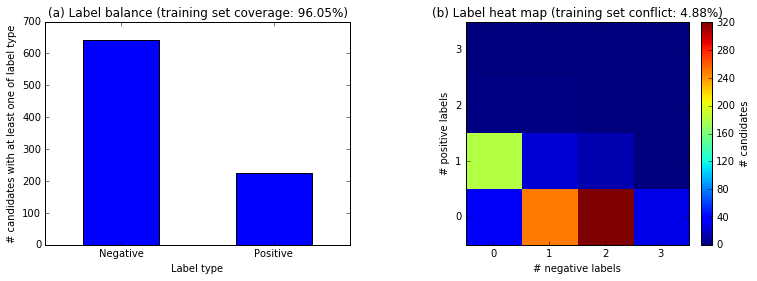

In [427]:
DDL.print_lf_stats()
DDL.plot_lf_stats()


Begin training for rate=0.01, mu=1e-07
	Learning epoch = 0	Gradient mag. = 0.316057
	Learning epoch = 250	Gradient mag. = 0.481987
Final gradient magnitude for rate=0.01, mu=1e-07: 0.597
Running in False mode...
Begin training for rate=0.01, mu=1e-09
	Learning epoch = 0	Gradient mag. = 0.055793
	Learning epoch = 250	Gradient mag. = 0.058497
	Learning epoch = 500	Gradient mag. = 0.058266
	Learning epoch = 750	Gradient mag. = 0.058038
	Learning epoch = 1000	Gradient mag. = 0.057811
	Learning epoch = 1250	Gradient mag. = 0.057587
	Learning epoch = 1500	Gradient mag. = 0.057364
	Learning epoch = 1750	Gradient mag. = 0.057144
	Learning epoch = 2000	Gradient mag. = 0.056925
	Learning epoch = 2250	Gradient mag. = 0.056708
	Learning epoch = 2500	Gradient mag. = 0.056493
	Learning epoch = 2750	Gradient mag. = 0.056280
Final gradient magnitude for rate=0.01, mu=1e-09: 0.056
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.055793
	Learning epoch = 250	Gradient mag. = 0

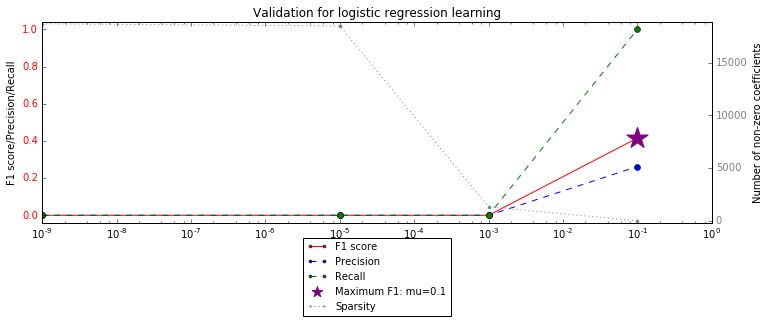

CPU times: user 29.1 s, sys: 417 ms, total: 29.5 s
Wall time: 29.8 s


<snorkel.snorkel.ModelLog instance at 0x14586fcb0>

In [428]:
import matplotlib
import numpy as np
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (12,4)
mu_seq = np.ravel([1e-9, 1e-5, 1e-3, 1e-1])
lf_opts = {'sample': False, 'verbose': True}
model_opts = {'sample': False, 'n_iter': 3000, 'alpha': 0.5, 'mu': mu_seq, 'bias': False, 'verbose': True}
%time DDL.train_model(method='lr', lf_opts=lf_opts, model_opts=model_opts)